In [2]:
# Cell 1: imports and environment setup
# What this does: import required libraries and set plotting styles
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', context='talk')


In [3]:
# Cell 2: Download SPY daily data using yfinance
# What this does: fetches SPY price history and computes log returns
symbol = 'SPY'
start = '2005-01-01'
end = datetime.today().strftime('%Y-%m-%d')

df = yf.download(symbol, start=start, end=end, progress=False)
df = df[('Close', 'SPY')].to_frame(name='close') # Extract 'Close' and rename to 'close'
df['logret'] = np.log(df['close']).diff() # Calculate log returns using the 'close' column
df.dropna(inplace=True)
df.reset_index(inplace=True) # Reset index to make 'Date' a column
df.rename(columns={'index': 'Date'}, inplace=True) # Rename the index column to 'Date'
print(df.head())

        Date      close    logret
0 2005-01-04  80.847015 -0.012294
1 2005-01-05  80.289101 -0.006925
2 2005-01-06  80.697304  0.005071
3 2005-01-07  80.581665 -0.001434
4 2005-01-10  80.962654  0.004717


In [4]:
# Cell 3: Feature engineering - rolling vol, momentum, returns
# What this does: creates rolling volatility, momentum, and returns as features
window_vol = 21  # ~1 month trading days
window_mom = 5   # short momentum

df['ret_1d'] = df['logret']
df['vol_21d'] = df['logret'].rolling(window_vol).std() * np.sqrt(252)  # annualized vol proxy
df['mom_5d'] = df['close'].pct_change(window_mom)
df.dropna(inplace=True)

features = df[['ret_1d', 'vol_21d', 'mom_5d']].copy()
print(features)


        ret_1d   vol_21d    mom_5d
20    0.003023  0.100447  0.017401
21   -0.002602  0.091181  0.013029
22    0.010620  0.094462  0.023844
23   -0.001332  0.093488  0.016164
24    0.001166  0.093215  0.010933
...        ...       ...       ...
5226  0.015228  0.126790 -0.012760
5227 -0.001222  0.125707 -0.010297
5228  0.004430  0.126381 -0.011796
5229 -0.006834  0.128815 -0.015674
5230  0.005660  0.129293  0.017411

[5211 rows x 3 columns]


Why these features?


*   ret_1d captures immediate returns.
*   vol_21d captures market uncertainty (regimes often defined by volatility).

* mom_5d short-term trend; momentum vs mean-revert regimes can be separated here.

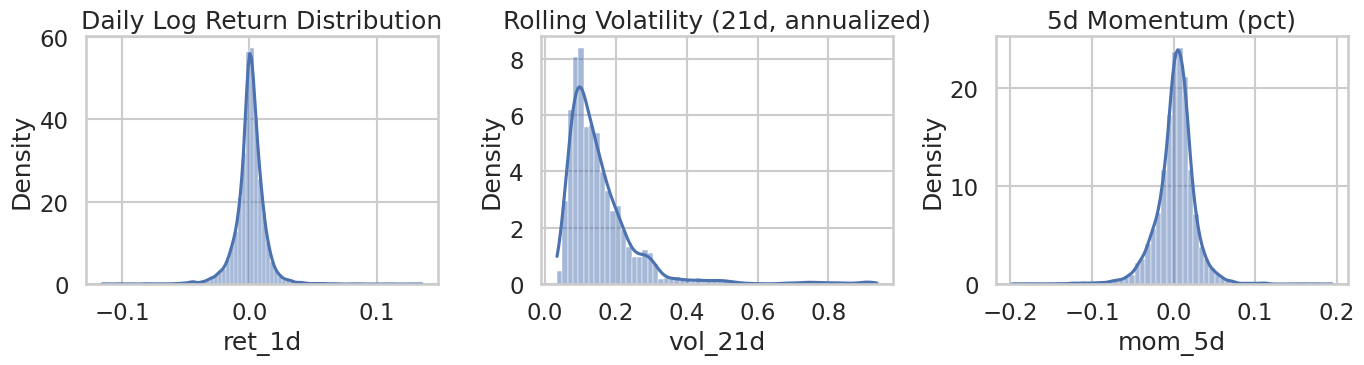

In [5]:
# Cell 4: Plot histograms and density plots for features
# What this does: visualizes marginal distributions for returns and vol
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.histplot(features['ret_1d'], kde=True, stat='density', bins=80)
plt.title('Daily Log Return Distribution')

plt.subplot(1,3,2)
sns.histplot(features['vol_21d'], kde=True, stat='density', bins=60)
plt.title('Rolling Volatility (21d, annualized)')

plt.subplot(1,3,3)
sns.histplot(features['mom_5d'].dropna(), kde=True, stat='density', bins=60)
plt.title('5d Momentum (pct)')
plt.tight_layout()
plt.show()


Interpretation:

* Returns: heavy tails and skewness — not Gaussian.

* Volatility: skewed, long right tail — crisis spikes.

* Momentum: symmetric-ish but depends on regime.

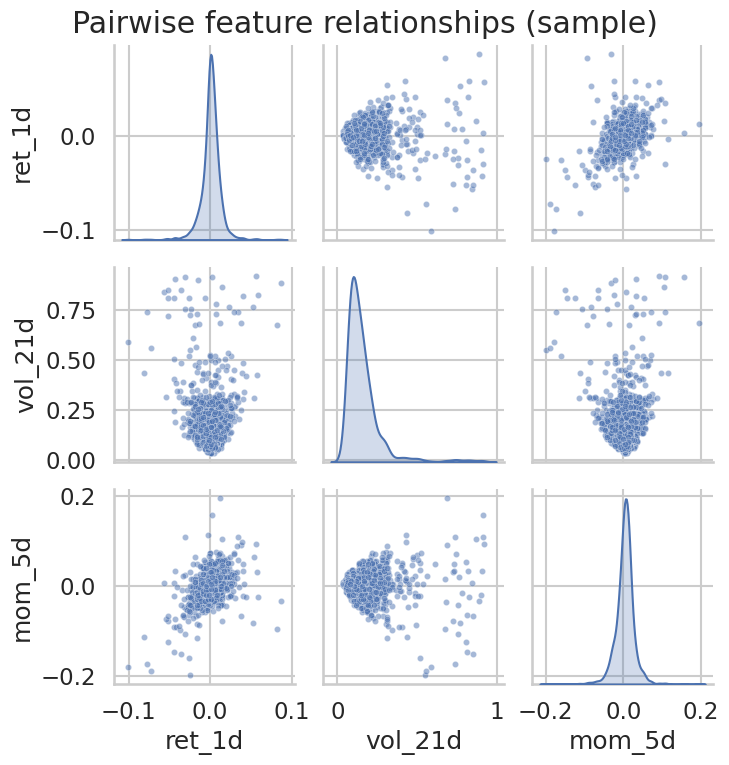

Correlation matrix:
            ret_1d   vol_21d    mom_5d
ret_1d   1.000000 -0.007986  0.423119
vol_21d -0.007986  1.000000 -0.056426
mom_5d   0.423119 -0.056426  1.000000


In [6]:
# Cell 5: Scatter and correlation plots between features
# What this does: shows pairwise relationships between features
sns.pairplot(features.sample(2000), diag_kind='kde', plot_kws={'alpha':0.5, 's':20})
plt.suptitle('Pairwise feature relationships (sample)', y=1.02)
plt.show()

print("Correlation matrix:\n", features.corr())


Interpretation:
* Volatility and returns often weakly negatively correlated - spikes in vol accompany negative returns.
* Momentum versus returns: depends on lookback.

*Feature scaling note:* We'll need to scale features before feeding models. LGMM can work on raw features but scaling makes clusters comparable. VAE and Transformer greatly benefit from standardized inputs.

### c LGMM Regime Clustering

In [7]:
# Cell 6: Prepare scaled features for clustering
# What this does: standardizes features for all models
scaler = StandardScaler()
X = scaler.fit_transform(features.values)
dates = features.index


In [8]:
# Cell 7: Fit Gaussian Mixture (LGMM) and assign regimes
# What this does: fits GaussianMixture with n_components and labels each day
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
gmm.fit(X)
lgmm_labels = gmm.predict(X)


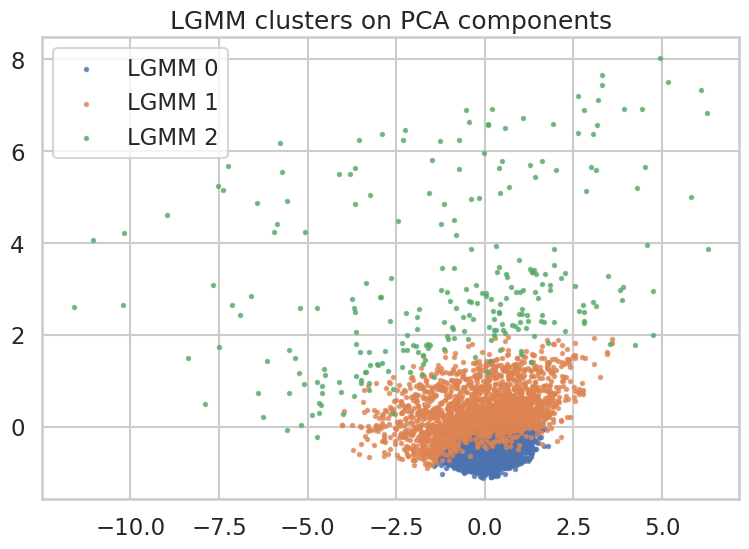

In [9]:
# Cell 8: Visualize LGMM clusters on PCA-projected 2D space
# What this does: projects features to 2D (PCA) and plots points colored by LGMM cluster
pca = PCA(n_components=2)
Xp = pca.fit_transform(X)
plt.figure(figsize=(9,6))
for k in range(n_clusters):
    plt.scatter(Xp[lgmm_labels==k,0], Xp[lgmm_labels==k,1], s=6, alpha=0.7, label=f'LGMM {k}')
plt.title('LGMM clusters on PCA components')
plt.legend()
plt.show()


Interpretation:
* Each LGMM cluster typically corresponds to regimes: a low-vol, small-return cluster; a moderate cluster; and a high-vol, large-negative-return cluster (crisis).
* Inspect cluster statistics for meaning:

In [10]:
# Cell 9: Summarize cluster statistics in original feature space
# What this does: prints mean and std of features per LGMM cluster for interpretation
df_lgmm = features.copy()
df_lgmm['lgmm'] = lgmm_labels
print(df_lgmm.groupby('lgmm').agg(['mean','std']).T)


lgmm                 0         1         2
ret_1d  mean  0.000979  0.000009 -0.003098
        std   0.005179  0.012877  0.036290
vol_21d mean  0.099595  0.196553  0.512515
        std   0.027444  0.053748  0.198117
mom_5d  mean  0.005942 -0.000983 -0.013567
        std   0.010978  0.027237  0.064227


What this tells you:

* Cluster with highest vol_21d.mean usually is crisis.

* Cluster with positive mom_5d.mean and lower vol likely trend/stable.

### d. Variational Autoencoder (VAE) Latent Modeling

In [11]:
# Cell 10: Build and train a simple VAE in PyTorch
# What this does: defines VAE architecture and training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=False)

latent_dim = 2
input_dim = X.shape[1]
hidden_dim = 16
lr = 1e-3
epochs = 80

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, input_dim)
        self.act = nn.ReLU()
    def encode(self, x):
        h = self.act(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h = self.act(self.fc_decode(z))
        return self.fc_out(h)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

model = VAE(input_dim, hidden_dim, latent_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)


In [12]:
# Cell 11: VAE training loop
# What this does: trains the VAE with reconstruction + KL loss
def loss_fn(recon, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon, x, reduction='sum')
    # KL divergence between posterior q(z|x) and N(0,1)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

model.train()
for ep in range(epochs):
    total_loss = 0.0
    for batch in loader:
        x_batch = batch[0]
        opt.zero_grad()
        recon, mu, logvar = model(x_batch)
        loss = loss_fn(recon, x_batch, mu, logvar)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    if (ep+1) % 10 == 0:
        print(f'Epoch {ep+1}/{epochs} - loss: {total_loss/len(X):.4f}')


Epoch 10/80 - loss: 2.6928
Epoch 20/80 - loss: 2.1864
Epoch 30/80 - loss: 2.1450
Epoch 40/80 - loss: 2.1221
Epoch 50/80 - loss: 2.0890
Epoch 60/80 - loss: 2.1104
Epoch 70/80 - loss: 2.0920
Epoch 80/80 - loss: 2.0722


In [13]:
# Cell 12: Get latent codes for all points and KMeans cluster them
# What this does: encodes data into 2D latent space and clusters with KMeans
model.eval()
with torch.no_grad():
    mu, logvar = model.encode(X_tensor)
    z = mu.cpu().numpy()  # use mean as deterministic code

kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(z)
vae_labels = kmeans.labels_


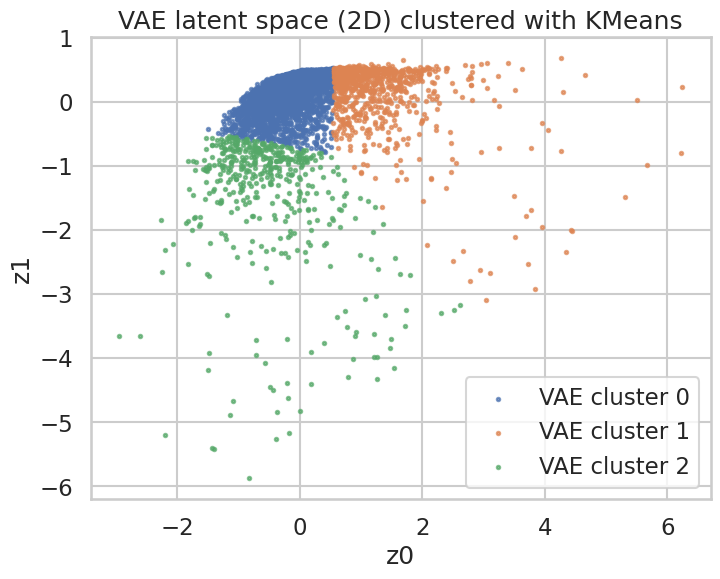

In [14]:
# Cell 13: Plot VAE latent space colored by KMeans cluster
# What this does: plots 2D latent points and colors by VAE KMeans cluster
plt.figure(figsize=(8,6))
for k in range(n_clusters):
    plt.scatter(z[vae_labels==k,0], z[vae_labels==k,1], s=6, alpha=0.7, label=f'VAE cluster {k}')
plt.title('VAE latent space (2D) clustered with KMeans')
plt.legend()
plt.xlabel('z0'); plt.ylabel('z1')
plt.show()


In [15]:
# Cell 14: Compare cluster stats for VAE clusters
# What this does: aggregate original features per VAE cluster for interpretation
df_vae = features.copy()
df_vae['vae'] = vae_labels
print(df_vae.groupby('vae').agg(['mean','std']).T)


vae                  0         1         2
ret_1d  mean  0.001873 -0.015576  0.015023
        std   0.006283  0.014164  0.017429
vol_21d mean  0.121140  0.222539  0.359929
        std   0.047581  0.127334  0.184715
mom_5d  mean  0.006211 -0.031274  0.026122
        std   0.013892  0.026563  0.033634


### e Transformer Encoder for Sequence Modeling

In [16]:
# Cell 15: Create sequences for Transformer (rolling windows)
# What this does: constructs rolling overlapping sequences for each time t
seq_len = 16  # number of timesteps per sample
step = 1
X_seq = []
y_seq = []
for i in range(seq_len, len(X)):
    seq = X[i-seq_len:i]  # shape seq_len x feat_dim
    X_seq.append(seq)
    y_seq.append(vae_labels[i])  # target: VAE cluster for last day
X_seq = np.stack(X_seq)
y_seq = np.array(y_seq)
print("Sequences:", X_seq.shape, "Targets:", y_seq.shape)


Sequences: (5195, 16, 3) Targets: (5195,)


In [17]:
# Cell 16: Transformer encoder model in PyTorch
# What this does: defines a small Transformer encoder and classifier head
class TransEnc(nn.Module):
    def __init__(self, feat_dim, d_model=32, nhead=4, num_layers=2, dim_feedforward=64, n_classes=3):
        super().__init__()
        self.input_proj = nn.Linear(feat_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, n_classes)
        )
    def forward(self, x):  # x: batch x seq_len x feat_dim
        x = self.input_proj(x)  # -> batch x seq_len x d_model
        x = x.permute(1,0,2)    # transformer expects seq_len x batch x d_model
        out = self.transformer(x)  # seq_len x batch x d_model
        last = out[-1,:,:]  # take last timestep representation
        logits = self.classifier(last)
        return logits

# prepare data loaders
batch_size = 128
X_seq_t = torch.tensor(X_seq, dtype=torch.float32)
y_seq_t = torch.tensor(y_seq, dtype=torch.long)
dataset_seq = TensorDataset(X_seq_t, y_seq_t)
loader_seq = DataLoader(dataset_seq, batch_size=batch_size, shuffle=True)

# model + training
model_t = TransEnc(feat_dim=X.shape[1], n_classes=n_clusters).to(device)
opt_t = torch.optim.Adam(model_t.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epochs_t = 30


In [18]:
# Cell 17: Train Transformer encoder classifier to predict VAE clusters (self-supervised)
# What this does: trains transformer to predict regime labels derived from VAE
model_t.train()
for ep in range(epochs_t):
    total_loss = 0.0
    total_acc = 0.0
    for xb, yb in loader_seq:
        xb = xb.to(device); yb = yb.to(device)
        opt_t.zero_grad()
        logits = model_t(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt_t.step()
        total_loss += loss.item() * xb.size(0)
        total_acc += (logits.argmax(1) == yb).sum().item()
    if (ep+1) % 5 == 0:
        print(f'Epoch {ep+1}/{epochs_t} - loss {total_loss/len(dataset_seq):.4f} acc {total_acc/len(dataset_seq):.3f}')


Epoch 5/30 - loss 0.4356 acc 0.820
Epoch 10/30 - loss 0.4212 acc 0.822
Epoch 15/30 - loss 0.4164 acc 0.824
Epoch 20/30 - loss 0.4135 acc 0.826
Epoch 25/30 - loss 0.4120 acc 0.824
Epoch 30/30 - loss 0.4065 acc 0.831


In [19]:
# Cell 18: Get transformer predicted clusters for the timeline
# What this does: runs the transformer on sequences and collects predicted labels aligned with dates
model_t.eval()
with torch.no_grad():
    logits = model_t(X_seq_t.to(device))
    t_labels = logits.argmax(1).cpu().numpy()

# Align to full date index (first seq_len days will be NaN)
t_dates = dates[seq_len:]


### f Regime Label Comparison and Temporal Plots

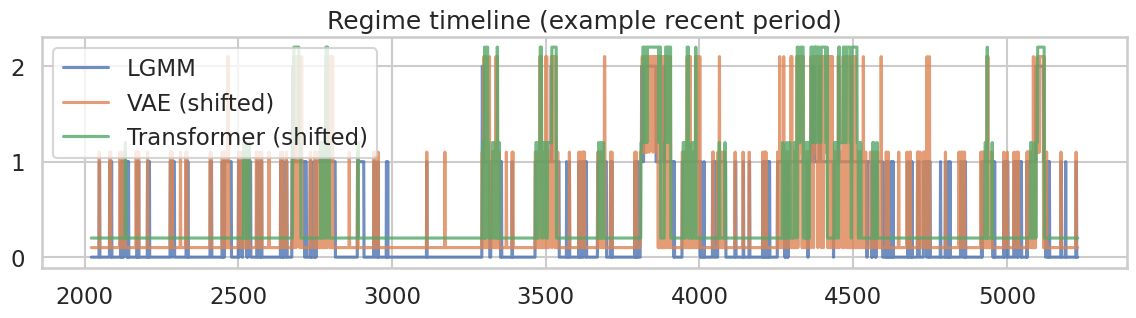

In [20]:
# Cell 19: Plot regime timeline (LGMM, VAE, Transformer) over time
# What this does: constructs a DataFrame with labels and plots regimes as stacked areas
label_df = pd.DataFrame(index=dates)
label_df['lgmm'] = lgmm_labels
label_df['vae'] = vae_labels
# align transformer (shorter)
label_df['transformer'] = np.nan
label_df.loc[t_dates, 'transformer'] = t_labels

# Plot regime timeline for a sample period (last 3 years for clarity)
start_plot = '2021-01-01'
dfp = label_df.loc[start_plot:]

plt.figure(figsize=(14,3))
plt.plot(dfp.index, dfp['lgmm'], label='LGMM', alpha=0.8)
plt.plot(dfp.index, dfp['vae']+0.1, label='VAE (shifted)', alpha=0.8)
plt.plot(dfp.index, dfp['transformer']+0.2, label='Transformer (shifted)', alpha=0.8)
plt.yticks([0,1,2])
plt.legend()
plt.title('Regime timeline (example recent period)')
plt.show()


In [21]:
# Cell 20: Quantify transition frequency
# What this does: counts number of regime changes per model per year
def transitions(series):
    s = series.dropna().astype(int)
    return (s.shift(1) != s).sum()

for name in ['lgmm','vae','transformer']:
    total_trans = transitions(label_df[name])
    print(f'{name}: total transitions (all data) = {total_trans}')


lgmm: total transitions (all data) = 533
vae: total transitions (all data) = 1133
transformer: total transitions (all data) = 321


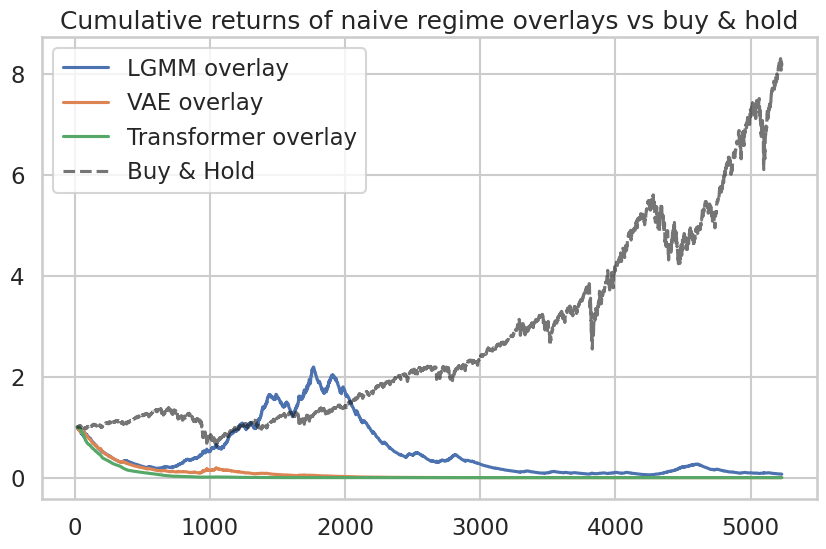

In [22]:
# Cell 21: Simple regime-based overlay backtest
# What this does: simulates daily P&L based on regime-specific rules applied to returns
rets = df['logret'].loc[label_df.index]
signals = pd.DataFrame(index=label_df.index, columns=['lgmm_sig','vae_sig','trans_sig'])

# helper: signal mapping function for a regime label
def regime_signal(row, label_col):
    lab = row[label_col]
    # naive mapping
    if lab == 0:
        # mean-reversion on 1d return: bet opposite of sign
        return -np.sign(row['ret_1d']) if row['ret_1d']!=0 else 0.0
    elif lab == 1:
        # trend: follow 5d momentum
        return np.sign(row['mom_5d']) if row['mom_5d']!=0 else 0.0
    else:
        # crisis: neutral or slight short
        return -0.5
# align features for lookup
label_input = features.copy()
label_input['lgmm'] = label_df['lgmm']
label_input['vae'] = label_df['vae']
label_input['transformer'] = label_df['transformer']

signals['lgmm_sig'] = label_input.apply(lambda r: regime_signal(r,'lgmm'), axis=1)
signals['vae_sig'] = label_input.apply(lambda r: regime_signal(r,'vae'), axis=1)
signals['trans_sig'] = label_input.apply(lambda r: regime_signal(r,'transformer') if not np.isnan(r['transformer']) else 0.0, axis=1)

# compute strat returns per day
strat = pd.DataFrame(index=signals.index)
strat['lgmm_rt'] = signals['lgmm_sig'] * rets
strat['vae_rt'] = signals['vae_sig'] * rets
strat['trans_rt'] = signals['trans_sig'] * rets
# cumulative returns
strat_cum = np.exp(strat.cumsum())  # because rets are log returns
plt.figure(figsize=(10,6))
plt.plot(strat_cum['lgmm_rt'], label='LGMM overlay')
plt.plot(strat_cum['vae_rt'], label='VAE overlay')
plt.plot(strat_cum['trans_rt'], label='Transformer overlay')
plt.plot(np.exp(rets.cumsum()), label='Buy & Hold', linestyle='--', color='k', alpha=0.6)
plt.legend()
plt.title('Cumulative returns of naive regime overlays vs buy & hold')
plt.show()


In [23]:
# Cell 22: Print numeric summary for last 3 years
print(strat_cum.loc['2021-01-01':].iloc[-1])
print("Annualized returns (approx):")
ann = (strat_cum.iloc[-1] ** (252/len(strat_cum))) - 1
print(ann)


lgmm_rt     6.889934e-02
vae_rt      2.933434e-06
trans_rt    2.766131e-11
Name: 5230, dtype: float64
Annualized returns (approx):
lgmm_rt    -0.121348
vae_rt     -0.459934
trans_rt   -0.691385
Name: 5230, dtype: float64


In [24]:
# Cell 23: Silhouette scores (higher better) computed in feature space
# What this does: computes silhouette score for clusters projected to PCA space
from sklearn.metrics import silhouette_score

print("Silhouette LGMM:", silhouette_score(Xp, lgmm_labels))
print("Silhouette VAE (kmeans on z):", silhouette_score(z, vae_labels))
# for transformer, we have labels only for times with sequences; compute on corresponding Xp slice
Xp_t = Xp[seq_len:]
print("Silhouette Transformer:", silhouette_score(Xp_t, t_labels))


Silhouette LGMM: 0.2829847150553496
Silhouette VAE (kmeans on z): 0.5451405
Silhouette Transformer: 0.41534163455364287


In [25]:
# Cell 24: ARI between clusterings
from sklearn.metrics import adjusted_rand_score
print("ARI LGMM vs VAE:", adjusted_rand_score(lgmm_labels, vae_labels))
# align transformer with others (drop initial seq_len)
print("ARI LGMM vs Transformer:", adjusted_rand_score(lgmm_labels[seq_len:], t_labels))
print("ARI VAE vs Transformer:", adjusted_rand_score(vae_labels[seq_len:], t_labels))


ARI LGMM vs VAE: 0.3479033907127013
ARI LGMM vs Transformer: 0.2866277795176442
ARI VAE vs Transformer: 0.515211406944186


In [26]:
# Cell 25: Confusion matrix between LGMM and VAE clusters
# What this does: prints contingency matrix to show how clusters map to each other
cm = contingency_matrix(lgmm_labels, vae_labels)
print("Contingency matrix (LGMM rows x VAE cols):\n", cm)


Contingency matrix (LGMM rows x VAE cols):
 [[2933   36    0]
 [1037  635  306]
 [   1  112  151]]


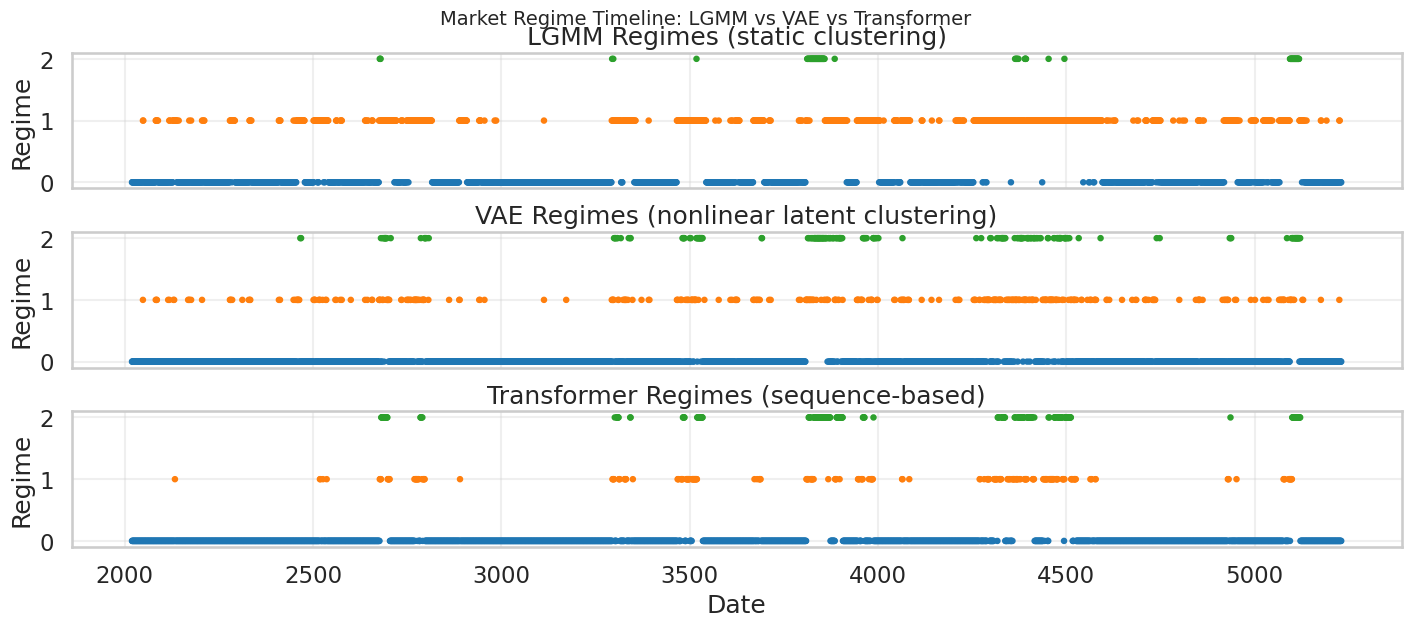

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- assumes label_df already exists with ['lgmm', 'vae', 'transformer'] indexed by date ---

# Optional: choose a sample period for readability (e.g., last 5 years)
start_plot = '2018-01-01'
end_plot = None
subset = label_df.loc[start_plot:end_plot].copy()

# Create the figure
fig, axes = plt.subplots(3, 1, figsize=(14, 6), sharex=True, constrained_layout=True)

# Define color maps for regimes
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green

# --- LGMM timeline ---
axes[0].scatter(subset.index, subset['lgmm'],
                c=subset['lgmm'].map({0:colors[0], 1:colors[1], 2:colors[2]}),
                s=10, label='LGMM regimes')
axes[0].set_title('LGMM Regimes (static clustering)')
axes[0].set_yticks([0,1,2])
axes[0].set_ylabel('Regime')

# --- VAE timeline ---
axes[1].scatter(subset.index, subset['vae'],
                c=subset['vae'].map({0:colors[0], 1:colors[1], 2:colors[2]}),
                s=10, label='VAE regimes')
axes[1].set_title('VAE Regimes (nonlinear latent clustering)')
axes[1].set_yticks([0,1,2])
axes[1].set_ylabel('Regime')

# --- Transformer timeline ---
axes[2].scatter(subset.index, subset['transformer'],
                c=subset['transformer'].map({0:colors[0], 1:colors[1], 2:colors[2]}),
                s=10, label='Transformer regimes')
axes[2].set_title('Transformer Regimes (sequence-based)')
axes[2].set_yticks([0,1,2])
axes[2].set_ylabel('Regime')

for ax in axes:
    ax.grid(alpha=0.3)
axes[-1].set_xlabel('Date')

plt.suptitle('Market Regime Timeline: LGMM vs VAE vs Transformer', fontsize=14, y=1.02)
plt.show()


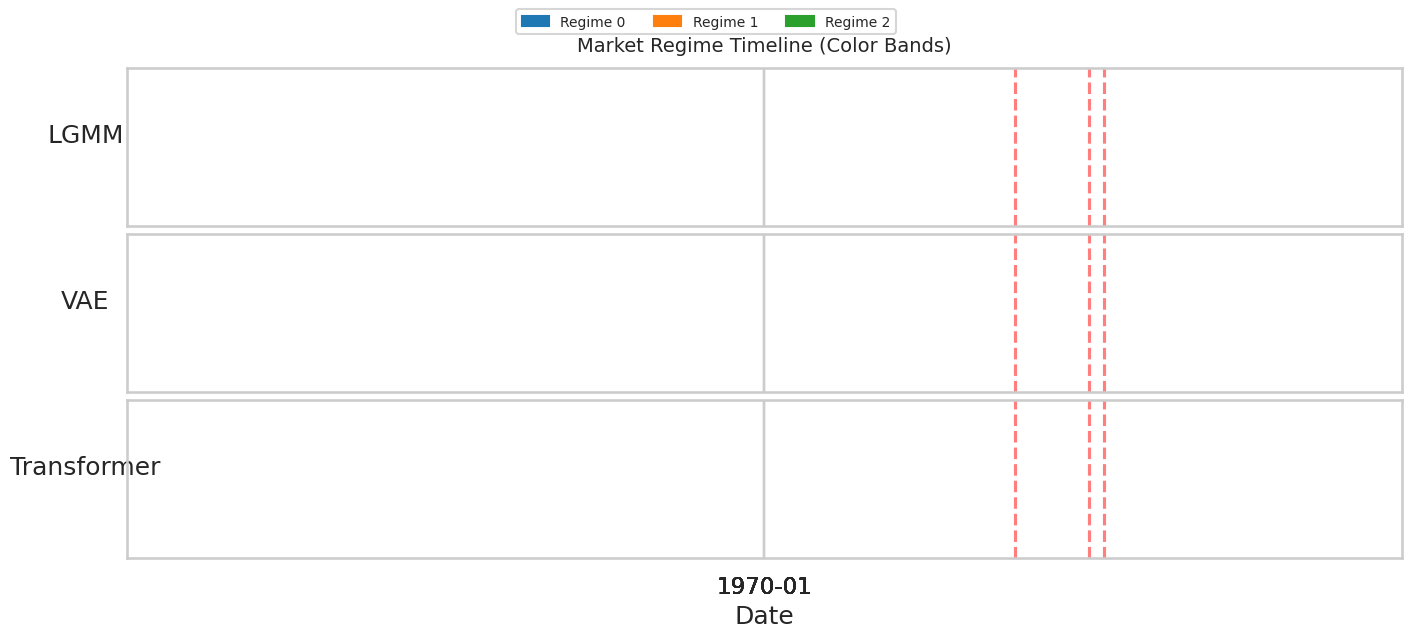

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Patch

# --- Step 1: clean + prep ---
label_df.index = pd.to_datetime(label_df.index)        # make sure index is datetime
label_df = label_df.dropna(subset=['lgmm','vae','transformer'])

# auto-adjust window
start_plot = label_df.index.min()
end_plot = label_df.index.max()
subset = label_df.loc[start_plot:end_plot].copy()

# convert to ordinal (numeric)
x0, x1 = subset.index[0].toordinal(), subset.index[-1].toordinal()

# --- Step 2: create 2D regime arrays ---
Z_lgmm = np.expand_dims(subset['lgmm'].values, axis=0)
Z_vae = np.expand_dims(subset['vae'].values, axis=0)
Z_trans = np.expand_dims(subset['transformer'].values, axis=0)

# --- Step 3: consistent colors ---
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green
cmap = plt.matplotlib.colors.ListedColormap(colors)

# --- Step 4: figure layout ---
fig, axes = plt.subplots(3, 1, figsize=(14, 6), sharex=True, constrained_layout=True)

# LGMM
axes[0].imshow(Z_lgmm, aspect='auto', cmap=cmap, extent=[x0, x1, 0, 1])
axes[0].set_yticks([]); axes[0].set_ylabel('LGMM', rotation=0, labelpad=30)
axes[0].set_title('Market Regime Timeline (Color Bands)', fontsize=14, pad=12)

# VAE
axes[1].imshow(Z_vae, aspect='auto', cmap=cmap, extent=[x0, x1, 0, 1])
axes[1].set_yticks([]); axes[1].set_ylabel('VAE', rotation=0, labelpad=30)

# Transformer
axes[2].imshow(Z_trans, aspect='auto', cmap=cmap, extent=[x0, x1, 0, 1])
axes[2].set_yticks([]); axes[2].set_ylabel('Transformer', rotation=0, labelpad=30)

# --- Step 5: format x-axis ---
xticks = np.linspace(x0, x1, 8)
axes[-1].set_xticks(xticks)
axes[-1].set_xticklabels([pd.Timestamp.fromordinal(int(x)).strftime('%Y-%m') for x in xticks])
axes[-1].set_xlabel('Date')

# --- Step 6: mark major crises (optional) ---
for ax in axes:
    for crisis in ['2008-10-01', '2020-03-01', '2022-06-01']:
        ax.axvline(pd.Timestamp(crisis).toordinal(), color='red', linestyle='--', alpha=0.5)

# --- Step 7: legend ---
legend_elems = [Patch(color=c, label=f'Regime {i}') for i, c in enumerate(colors)]
fig.legend(handles=legend_elems, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05), fontsize=10)

plt.show()
